In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), 'src', 'pycausal', 'lib')
# print py-causal_libdir

In [3]:
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print l
    javabridge.JARS.append(str(l))

/Users/chw20/Documents/DBMI/py-causal/src/pycausal/lib/tetrad-lib-5.3.0-SNAPSHOT-tetradcmd.jar


In [4]:
javabridge.start_vm(run_headless=True, max_heap_size = '1000M')
javabridge.attach()

In [5]:
data_dir = os.path.join(os.getcwd(), 'data', 'audiology.txt')
data_dir

'/Users/chw20/Documents/DBMI/py-causal/data/audiology.txt'

In [6]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,age_gt_60,air,airBoneGap,ar_c,ar_u,bone,boneAbnormal,bser,history_buzzing,history_dizziness,...,s_sn_gt_2k,s_sn_gt_4k,speech,static_normal,tymp,viith_nerve_signs,wave_V_delayed,waveform_ItoV_prolonged,indentifier,class
0,f,mild,f,normal,normal,?,t,?,f,f,...,f,f,normal,t,a,f,f,f,p1,cochlear_unknown
1,f,moderate,f,normal,normal,?,t,?,f,f,...,f,f,normal,t,a,f,f,f,p2,cochlear_unknown
2,t,mild,t,?,absent,mild,t,?,f,f,...,f,f,normal,t,as,f,f,f,p3,mixed_cochlear_age_fixation
3,t,mild,t,?,absent,mild,f,?,f,f,...,f,f,normal,t,b,f,f,f,p4,mixed_cochlear_age_otitis_media
4,t,mild,f,normal,normal,mild,t,?,f,f,...,f,f,good,t,a,f,f,f,p5,cochlear_age


In [7]:
dataBox = javabridge.JWrapper(javabridge.make_instance("edu/cmu/tetrad/data/VerticalIntDataBox","(II)V",
                                            len(dframe.index),dframe.columns.size))

In [8]:
node_list = javabridge.JWrapper(javabridge.make_instance("java/util/ArrayList", "()V"))
# load dataset
col_no = 0
for col in dframe.columns:
    
    cat_array = sorted(set(dframe[col]))
    cat_list = javabridge.JWrapper(javabridge.make_instance("java/util/ArrayList", "()V"))
    
    nodname = javabridge.make_instance("java/lang/String", "(Ljava/lang/String;)V",col)
    
    for cat in cat_array:
        catname = javabridge.make_instance("java/lang/String", "(Ljava/lang/String;)V",cat)
        cat_list.add(catname)
        
    nodi = javabridge.make_instance("edu/cmu/tetrad/data/DiscreteVariable", 
                                    "(Ljava/lang/String;Ljava/util/List;)V",nodname, cat_list)
    node_list.add(nodi)
    
    for row in dframe.index:
        value = javabridge.make_instance("java/lang/Integer","(I)V", cat_array.index(dframe.ix[row][col_no]))
        dataBox.set(row,col_no,value)
    
    col_no = col_no + 1

In [9]:
boxData = javabridge.JWrapper(javabridge.make_instance("edu/cmu/tetrad/data/BoxDataSet",
                            "(Ledu/cmu/tetrad/data/DataBox;Ljava/util/List;)V", 
                            dataBox, node_list))

In [10]:
score = javabridge.JWrapper(javabridge.make_instance("edu/cmu/tetrad/search/BDeuScore",
                                                     "(Ledu/cmu/tetrad/data/DataSet;)V",boxData))

In [11]:
score.setStructurePrior(1.0)
score.setSamplePrior(1.0)

In [12]:
fgs = javabridge.make_instance("edu/cmu/tetrad/search/Fgs","(Ledu/cmu/tetrad/search/Score;)V",score)
fgs = javabridge.JWrapper(fgs)

In [13]:
fgs.setDepth(-1)
fgs.setNumPatternsToStore(0)
fgs.setFaithfulnessAssumed(True)
fgs.setParallelism(2)
fgs.setVerbose(True)

In [14]:
tetradGraph = fgs.search()

In [15]:
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: 
Graph Nodes:
age_gt_60 air airBoneGap ar_c ar_u bone boneAbnormal bser history_buzzing history_dizziness history_fluctuating history_fullness history_heredity history_nausea history_noise history_recruitment history_ringing history_roaring history_vomiting late_wave_poor m_at_2k m_cond_lt_1k m_gt_1k m_m_gt_2k m_m_sn m_m_sn_gt_1k m_m_sn_gt_2k m_m_sn_gt_500 m_p_sn_gt_2k m_s_gt_500 
m_s_sn m_s_sn_gt_1k m_s_sn_gt_2k m_s_sn_gt_3k m_s_sn_gt_4k m_sn_2_3k m_sn_gt_1k m_sn_gt_2k m_sn_gt_3k m_sn_gt_4k m_sn_gt_500 m_sn_gt_6k m_sn_lt_1k m_sn_lt_2k m_sn_lt_3k middle_wave_poor mod_gt_4k mod_mixed mod_s_mixed mod_s_sn_gt_500 mod_sn mod_sn_gt_1k mod_sn_gt_2k mod_sn_gt_3k mod_sn_gt_4k mod_sn_gt_500 notch_4k notch_at_4k o_ar_c o_ar_u 
s_sn_gt_1k s_sn_gt_2k s_sn_gt_4k speech static_normal tymp viith_nerve_signs wave_V_delayed waveform_ItoV_prolonged indentifier class 

Graph Edges: 
1. age_gt_60 --> m_m_sn
2. airBoneGap --> air
3. airBoneGa

In [16]:
tetradGraph.toString()

u'\nGraph Nodes:\nage_gt_60 air airBoneGap ar_c ar_u bone boneAbnormal bser history_buzzing history_dizziness history_fluctuating history_fullness history_heredity history_nausea history_noise history_recruitment history_ringing history_roaring history_vomiting late_wave_poor m_at_2k m_cond_lt_1k m_gt_1k m_m_gt_2k m_m_sn m_m_sn_gt_1k m_m_sn_gt_2k m_m_sn_gt_500 m_p_sn_gt_2k m_s_gt_500 \nm_s_sn m_s_sn_gt_1k m_s_sn_gt_2k m_s_sn_gt_3k m_s_sn_gt_4k m_sn_2_3k m_sn_gt_1k m_sn_gt_2k m_sn_gt_3k m_sn_gt_4k m_sn_gt_500 m_sn_gt_6k m_sn_lt_1k m_sn_lt_2k m_sn_lt_3k middle_wave_poor mod_gt_4k mod_mixed mod_s_mixed mod_s_sn_gt_500 mod_sn mod_sn_gt_1k mod_sn_gt_2k mod_sn_gt_3k mod_sn_gt_4k mod_sn_gt_500 notch_4k notch_at_4k o_ar_c o_ar_u \ns_sn_gt_1k s_sn_gt_2k s_sn_gt_4k speech static_normal tymp viith_nerve_signs wave_V_delayed waveform_ItoV_prolonged indentifier class \n\nGraph Edges: \n1. age_gt_60 --> m_m_sn\n2. airBoneGap --> air\n3. airBoneGap --> ar_u\n4. ar_c --> o_ar_u\n5. ar_u --> o_ar_c\n6.

In [17]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [age_gt_60, air, airBoneGap, ar_c, ar_u, bone, boneAbnormal, bser, history_buzzing, history_dizziness, history_fluctuating, history_fullness, history_heredity, history_nausea, history_noise, history_recruitment, history_ringing, history_roaring, history_vomiting, late_wave_poor, m_at_2k, m_cond_lt_1k, m_gt_1k, m_m_gt_2k, m_m_sn, m_m_sn_gt_1k, m_m_sn_gt_2k, m_m_sn_gt_500, m_p_sn_gt_2k, m_s_gt_500, m_s_sn, m_s_sn_gt_1k, m_s_sn_gt_2k, m_s_sn_gt_3k, m_s_sn_gt_4k, m_sn_2_3k, m_sn_gt_1k, m_sn_gt_2k, m_sn_gt_3k, m_sn_gt_4k, m_sn_gt_500, m_sn_gt_6k, m_sn_lt_1k, m_sn_lt_2k, m_sn_lt_3k, middle_wave_poor, mod_gt_4k, mod_mixed, mod_s_mixed, mod_s_sn_gt_500, mod_sn, mod_sn_gt_1k, mod_sn_gt_2k, mod_sn_gt_3k, mod_sn_gt_4k, mod_sn_gt_500, notch_4k, notch_at_4k, o_ar_c, o_ar_u, s_sn_gt_1k, s_sn_gt_2k, s_sn_gt_4k, speech, static_normal, tymp, viith_nerve_signs, wave_V_delayed, waveform_ItoV_prolonged, indentifier, class]

In [18]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [history_fluctuating --> class, history_fullness --- history_buzzing, airBoneGap --> ar_u, o_ar_u --> bone, speech --> air, history_dizziness --> history_roaring, class --> age_gt_60, history_fluctuating --> history_recruitment, m_sn_lt_1k --> history_fluctuating, history_noise --> class, history_dizziness --- static_normal, ar_u --> o_ar_c, ar_c --> o_ar_u, bone --> boneAbnormal, history_buzzing --- wave_V_delayed, s_sn_gt_2k --- history_heredity, notch_4k --- m_m_sn_gt_2k, history_recruitment --> m_sn_gt_1k, o_ar_c --> ar_c, history_vomiting --> history_roaring, age_gt_60 --> m_m_sn, history_dizziness --> history_fluctuating, tymp --> airBoneGap, history_roaring --> history_nausea, bser --- middle_wave_poor, airBoneGap --> air, middle_wave_poor --- late_wave_poor, class --> notch_at_4k, class --> tymp, history_roaring --> waveform_ItoV_prolonged]

In [19]:
graph = pydot.Dot(graph_type='digraph')

In [20]:
n = tetradGraph.getNodeNames().toString()
n = n[1:len(n)-1]
n = n.split(",")
nodes = []
for i in range(0,len(n)):
    node = n[i]
    n[i] = node.strip()
    nodes.append(pydot.Node(n[i]))
    graph.add_node(nodes[i])

In [21]:
def isNodeExisting(nodes,node):
    try:
        nodes.index(node)
        return True
    except IndexError:
        print "Node %s does not exist!", node
        return False

e = tetradGraph.getEdges().toString()
e = e[1:len(e)-1]
e = e.split(",")
for i in range(0,len(e)):
    e[i] = e[i].strip()
    token = e[i].split(" ")
    if(len(token) == 3):
        src = token[0]
        arc = token[1]
        dst = token[2]
        if(isNodeExisting(n,src) and isNodeExisting(n,dst)):
            edge = pydot.Edge(nodes[n.index(src)],nodes[n.index(dst)])
            if(arc == "---"):
                edge.set_arrowhead("none")
            graph.add_edge(edge)

In [22]:
svg_str = graph.create_svg(prog='dot')

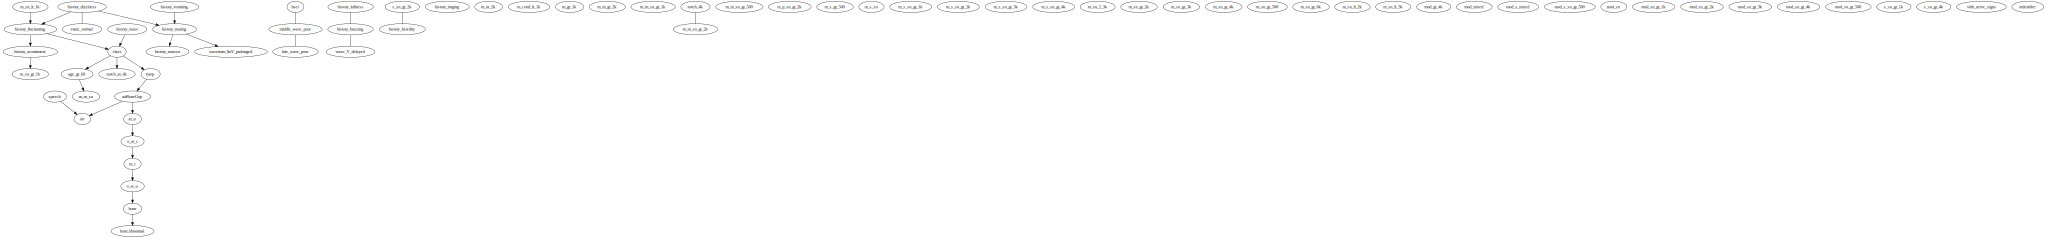

In [23]:
SVG(svg_str)

In [24]:
javabridge.detach()
javabridge.kill_vm()